Firstly here is a simple example of the Runge-Kutta method for solving differential equations:
'y_prime' defines the ODE, here it is: 
$${y´(t) = f(y(t), t) = 3t^2} $$

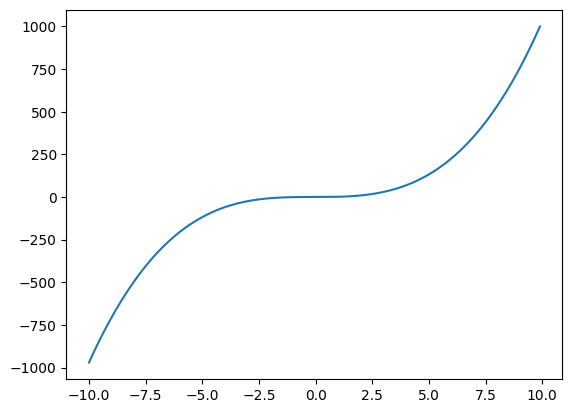

In [191]:
import numpy  as np
import matplotlib.pyplot as plt

    # calculate y(t + dt) 
def rk4_step(y, t, dt, y_prime: callable):
    k1 = y_prime(y, t)
    k2 = y_prime(y + k1*dt/2, t + dt/2)
    k3 = y_prime(y + k2*dt/2, t + dt/2)
    k4 = y_prime(y + k3*dt, t + dt)
    return y + (k1 + 2*k2 + 2*k3 + k4)*dt/6

def rk4(y0, t0, t1, step, y_prime: callable):
    y = y0
    t_list = np.arange(t0, t1, step)

    for t in t_list:
        y = rk4_step(y, t, step, y_prime)
        yield y


# example ODE: y_dot(t) = 3*t**2 => y(t) = t**3 analytically
def y_prime(y, t):
    return 3*t**2

# example start conditions and solving interval
t0 = -10
t1 = 10
step = 0.1
y0 = -1000

t_values = np.arange(t0, t1, step)
y_values = list(rk4(y0, t0, t1, step, y_prime))

plt.plot(t_values, y_values)
plt.show()




We put the parameters to our model in an extra class for better readability.
These values were fitted to the experimental data of Hodgkin and Huxley.


In [192]:
# CONSTANTS 

class HHParameters:
    def __init__(self):
        self.C_m = 1.0     # membrane capacitance, in uF/cm^2
        self.g_Na = 120.0  # maximum conductances, in mS/cm^2
        self.g_K = 36.0
        self.g_L = 0.3
        self.U_Na = 50.0   # Nernst reversal potentials, in mV
        self.U_K = -77.0
        self.U_L = -54.387
        self.U_pot = -65.0 # , in mV

params = HHParameters()

We collect the static methods alpha and beta in a class that doesnt need to be instantiated.

In [193]:

class HHGatingVariables:
    @staticmethod
    def alpha_n(U):
        return 0.01 * (U + 55) / (1 - np.exp(-(U + 55) / 10))
    
    @staticmethod
    def beta_n(U):
        return 0.125 * np.exp(-(U + 65) / 80)
    
    @staticmethod
    def alpha_m(U):
        return 0.1 * (U + 40) / (1 - np.exp(-(U + 40) / 10))
    
    @staticmethod
    def beta_m(U):
        return 4.0 * np.exp(-(U + 65) / 18)
    
    @staticmethod
    def alpha_h(U):
        return 0.07 * np.exp(-(U + 65) / 20)
    
    @staticmethod
    def beta_h(U):
        return 1 / (1 + np.exp(-(U + 35) / 10))

In [194]:
# contains n, m, h and U values and the math to compute the derivatives
class HHModel:
    def __init__(self, parameters):
        self.params = parameters
        self.U = self.params.U_pot  # initial membrane potential

        # we start with the gating variables in their equilibrium state:
        self.n = self._n_inf(self.U) 
        self.m = self._m_inf(self.U)
        self.h = self._h_inf(self.U)

    def _n_inf(self, U):
        return HHGatingVariables.alpha_n(U) / (HHGatingVariables.alpha_n(U) + HHGatingVariables.beta_n(U))
    
    def _m_inf(self, U):
        return HHGatingVariables.alpha_m(U) / (HHGatingVariables.alpha_m(U) + HHGatingVariables.beta_m(U))
    
    def _h_inf(self, U):
        return HHGatingVariables.alpha_h(U) / (HHGatingVariables.alpha_h(U) + HHGatingVariables.beta_h(U))

    def compute_derivatives(self, U, n, m, h, I_ext):
        dn = HHGatingVariables.alpha_n(U) * (1 - n) - HHGatingVariables.beta_n(U) * n
        dm = HHGatingVariables.alpha_m(U) * (1 - m) - HHGatingVariables.beta_m(U) * m
        dh = HHGatingVariables.alpha_h(U) * (1 - h) - HHGatingVariables.beta_h(U) * h
        
        I_Na = self.params.g_Na * m**3 * h * (U - self.params.U_Na)
        I_K = self.params.g_K * n**4 * (U - self.params.U_K)
        I_L = self.params.g_L * (U - self.params.U_L)
        
        dU = (I_ext - I_Na - I_K - I_L) / self.params.C_m
        
        return np.array([dU, dn, dm, dh])

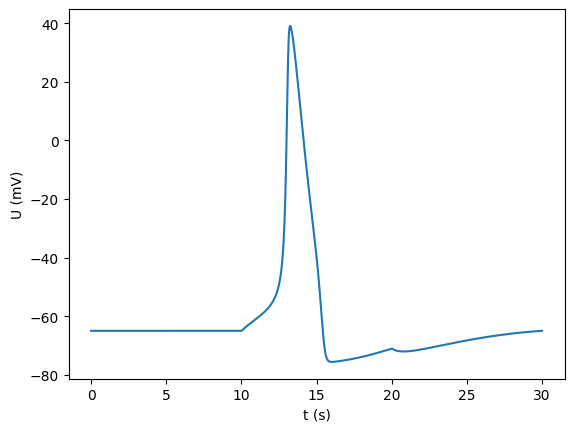

In [195]:
# runs a simulation using the classical Runge-Kutta method to solve the ODE
class HHSimulationClassicalRungeKutta:
    def __init__(self, hh_model, time, dt, I_ext):
        self.hh_model = hh_model
        self.time = time
        self.dt = dt
        self.I_ext = I_ext
        self.U_values = []
        self.t_values = np.arange(0, time, dt)

    def run(self):
        U = self.hh_model.U
        n = self.hh_model.n
        m = self.hh_model.m
        h = self.hh_model.h

        for t in self.t_values:
            self.U_values.append(U)
            
            y = [U,n,m,h]
            I_ext = self.I_ext(t)

            k1 = self.hh_model.compute_derivatives(*y, self.I_ext(t))
            k2 = self.hh_model.compute_derivatives(*(y + k1*self.dt/2), I_ext)
            k3 = self.hh_model.compute_derivatives(*(y + k2*self.dt/2), I_ext)
            k4 = self.hh_model.compute_derivatives(*(y + k3*self.dt), I_ext)

            U, n, m, h = y + (k1 + 2*k2 + 2*k3 + k4)*self.dt/6

        return self.t_values, self.U_values

# returns the external current for the simulated neuron in nA
def I_ext(t):
    return 5 if 10 < t < 20 else 0

hhModel = HHModel(params)
rk_sim = HHSimulationClassicalRungeKutta(hhModel, time=30, dt=0.01, I_ext=I_ext)
t_values, U_values = rk_sim.run()

plt.plot(t_values, U_values)
plt.ylabel("U (mV)")
plt.xlabel("t (s)")
plt.show()

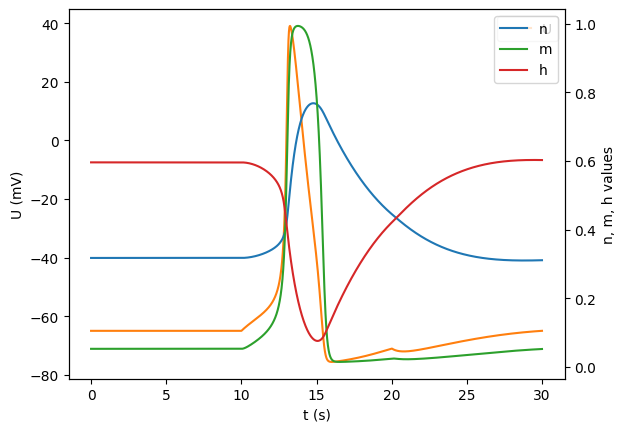

In [196]:
from scipy.integrate import odeint

# runs a simulation using the odeint method to solve the ODE
class HHSimulationOdeint:
    def __init__(self, hh_model, time, dt, I_ext):
        self.hh_model = hh_model
        self.time = time
        self.dt = dt
        self.I_ext = I_ext
        self.U_values = []
        self.t_values = np.arange(0, time, dt)

    def run(self):
        y0 = [self.hh_model.U, self.hh_model.n, self.hh_model.m, self.hh_model.h]
        return self.t_values, odeint(self.compute_derivatives_wrapper, y0, self.t_values)

    # wrapper to match odeint´s required call signature, because compute_derivatives does not need t as input
    def compute_derivatives_wrapper(self, y, t):
        return self.hh_model.compute_derivatives(*y, self.I_ext(t))

hhModel = HHModel(params)
odeint_sim = HHSimulationOdeint(hhModel, time=30, dt=0.01, I_ext=I_ext)
t, y = odeint_sim.run()

fig, ax1 = plt.subplots()
ax1.set_xlabel("t (s)")
ax1.set_ylabel("U (mV)")
ax1.plot(t, y[:,0], color='tab:orange', label="U")
plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("n, m, h values")
ax2.plot(t, y[:,1], color='tab:blue', label="n")

ax2.plot(t, y[:,2], color='tab:green', label="m")
ax2.plot(t, y[:,3], color='tab:RED', label="h")
plt.legend()

plt.show()

value out of bound with Runge-Kutta at dt = 0.096 ('underflow encountered in exp',)
value out of bound with Runge-Kutta at dt = 0.097 ('underflow encountered in exp',)
value out of bound with Runge-Kutta at dt = 0.098 ('underflow encountered in exp',)
value out of bound with Runge-Kutta at dt = 0.099 ('underflow encountered in exp',)
value out of bound with Runge-Kutta at dt = 0.1 ('overflow encountered in exp',)
value out of bound with Runge-Kutta at dt = 0.101 ('overflow encountered in scalar power',)
value out of bound with Runge-Kutta at dt = 0.10200000000000001 ('overflow encountered in exp',)
value out of bound with Runge-Kutta at dt = 0.10300000000000001 ('underflow encountered in exp',)
value out of bound with Runge-Kutta at dt = 0.10400000000000001 ('underflow encountered in exp',)
value out of bound with Runge-Kutta at dt = 0.10500000000000001 ('underflow encountered in exp',)
value out of bound with Runge-Kutta at dt = 0.106 ('underflow encountered in exp',)
value out of bou

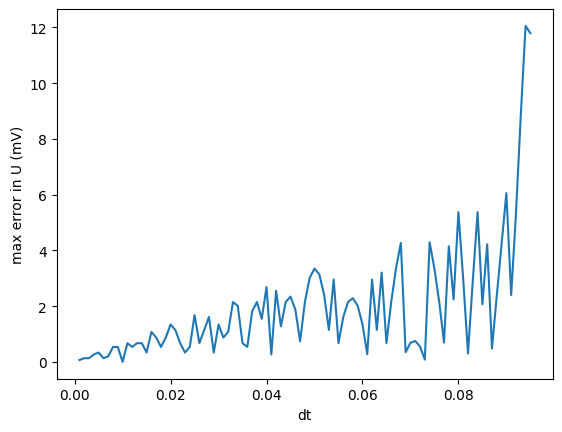

In [206]:

# plot maximum difference against dt when using Runge-Kutta
dt_list = np.arange(0.001, 0.2, 0.001)
errors_rk = np.zeros(len(dt_list))

for i, dt in enumerate(dt_list):
    try:
        __, U = HHSimulationClassicalRungeKutta(HHModel(params), 30, dt, I_ext).run()
        __, accurate_values = HHSimulationOdeint(HHModel(params), 30, dt, I_ext).run()

        max_difference = max(U - accurate_values[:,0])
        errors_rk[i] = max_difference

    except FloatingPointError  as e:
        print("value out of bound with Runge-Kutta at dt =", dt, e.args)
        errors_rk[i] = np.inf
        continue


plt.plot(dt_list, errors_rk)
plt.xlabel("dt")
plt.ylabel("max error in U (mV)")
plt.show()
